# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

---

## Zestaw zadań 6: Klasteryzacja, agregacja i autokorelacja danych

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans

In [2]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")
cmap = plt.colormaps["YlOrBr"]

In [3]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań
def point_count_on_subregions(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    bin_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    hist, x, y = np.histogram2d(points["X"], points["Y"], bins = bins, range = [x_lim, y_lim])
    return [x, y, hist.transpose()]

### Przygotowanie danych
Wczytaj dane zawarte w plikach CSV załączonych do zestawu zadań.

In [4]:
df1 = pd.read_csv("points_1.csv")
df2 = pd.read_csv("points_2.csv")
df3 = pd.read_csv("points_3.csv")

### Zadanie 1: Klasteryzacja metodą k-średnich (11 pkt)

Przygotuj funkcję `k_means_elbow_curve_test()`, która będzie wykonywała klasteryzację danych dla ustalonego zakresu liczby klastrów oraz obliczała dane niezbędne do wykreślenia wykresu typu elbow curve, na podstawie którego można podjąć decyzję na temat optymalnej liczby klastrów.

Następnie wykorzystaj przygotowaną funkcję do podzielenia na optymalną liczbę klastrów rozkładu punktów z pliku points_1.csv. 

Przedstaw wyniki analizy graficznie w postaci wykresu liniowego (elbow curve) oraz rozkładu punktów podzielonego na optymalną liczbę klastrów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [5]:
def k_means_elbow_curve_test(points, number_of_clusters):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    number_of_clusters: list
        Lista określająca zakres testowanej liczby klastrów.
        Przykład: [1, 5]   

    Returns
    -------
    clusters: DataFrame
        Tablica zbierająca wyniki klasteryzacji w następujących kolumnach:
        - "X" - współrzędne X punktów,
        - "Y" - współrzedne Y punktów,
        - kolejne kolumny (ich liczba zależy od liczby testowanych liczebności klastrów) opisane są jako liczba klastrów,
        np. "1", "2", itd. i zawierają numery klastrów, do których zostały przyporządkowane konkretne punkty.
    elbow_curve: DataFrame
        Tablica zbierająca dane niebędne do wykonania wykresu elbow curve w dwóch kolumnach:
        - "N" - liczba klastrów,
        - "D(N)" - średnia odległość punktu od centrum klastra, do którego jest przypisany.
    """
    nClust = range(number_of_clusters[0], number_of_clusters[1] + 1)
    clusters = points.copy()
    D_N = []
    
    for n in nClust:
        kmeans = KMeans(n).fit(points)
        clusters[str(n)] = kmeans.labels_
        distances = []
        
        for i in range(n): 
            df = clusters[clusters[str(n)] == i]
            df = df[["X", "Y"]]
            xC, yC = kmeans.cluster_centers_[i]   
            distances.extend([((pX-xC)**2 + (pY-yC)**2)**0.5 for pX, pY in df.to_numpy()])
       
        D_N.append(np.mean(distances))
        
    elbow_curve = pd.DataFrame({"N" : nClust, "D(N)" : D_N})
    
    return clusters, elbow_curve

#### b) Wygenerowanie danych

In [6]:
clusters, elbow_curve = k_means_elbow_curve_test(df1, [1, 10])

#### c) Wizualizacja

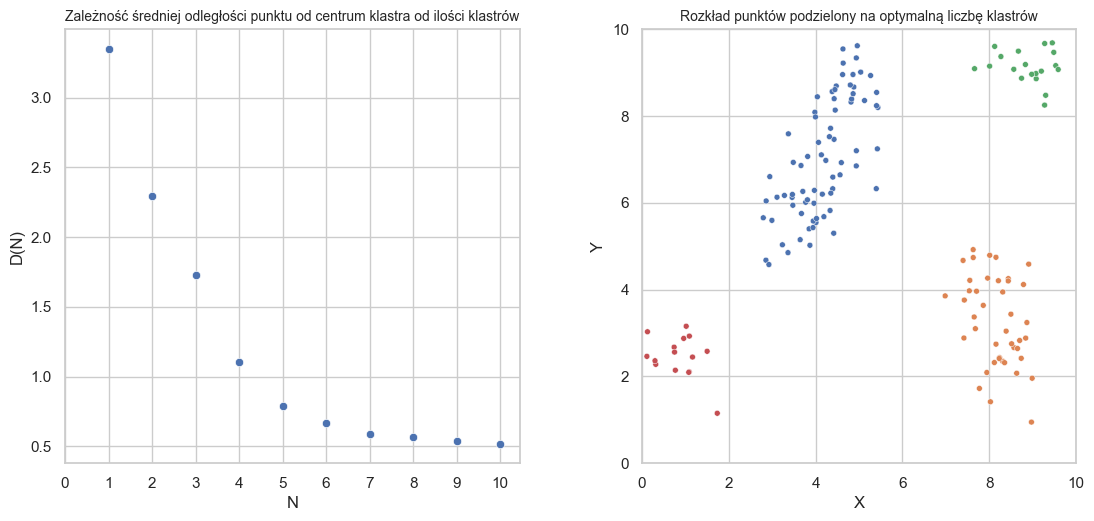

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))
fig.tight_layout(pad=4.0)

sns.scatterplot(data = elbow_curve, x = "N", y = "D(N)", ax = axes[0])
axes[0].set_xticks(range(11));
axes[0].set_title("Zależność średniej odległości punktu od centrum klastra od ilości klastrów", fontsize = 10);

sns.scatterplot(data = clusters, x = "X", y = "Y", size = 1, hue = clusters["4"], palette = 'deep')
axes[1].axis('square')
axes[1].set_ylim([0,10]);
axes[1].set_xlim([0,10]);
axes[1].legend([], [], frameon=False)
axes[1].set_title("Rozkład punktów podzielony na optymalną liczbę klastrów", fontsize = 10);

### Zadanie 2: Agregacja danych na siatce prostokątnej (6 pkt)

Przygotuj funkcję `agregate_on_rectangles()`, która będzie zliczać punkty w obrębie prostokątnych podobszarów.

Następnie wykorzystaj przygotowaną funkcję do zagregowania rozkładów punktów z plików points_2.csv i points_3.csv. Ustaw podział obszaru na 40 podobszarów wzdłuż osi $x$ i 20 podobszarów wzdłuż osi $y$.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [8]:
def agregate_on_rectangles(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    return point_count_on_subregions(points, bins, x_lim, y_lim)

#### b) Wygenerowanie danych

In [9]:
binned_data2 = agregate_on_rectangles(df2, [40,20], [0,20], [0,10])
binned_data3 = agregate_on_rectangles(df3, [40,20], [0,20], [0,10])

#### c) Wizualizacja

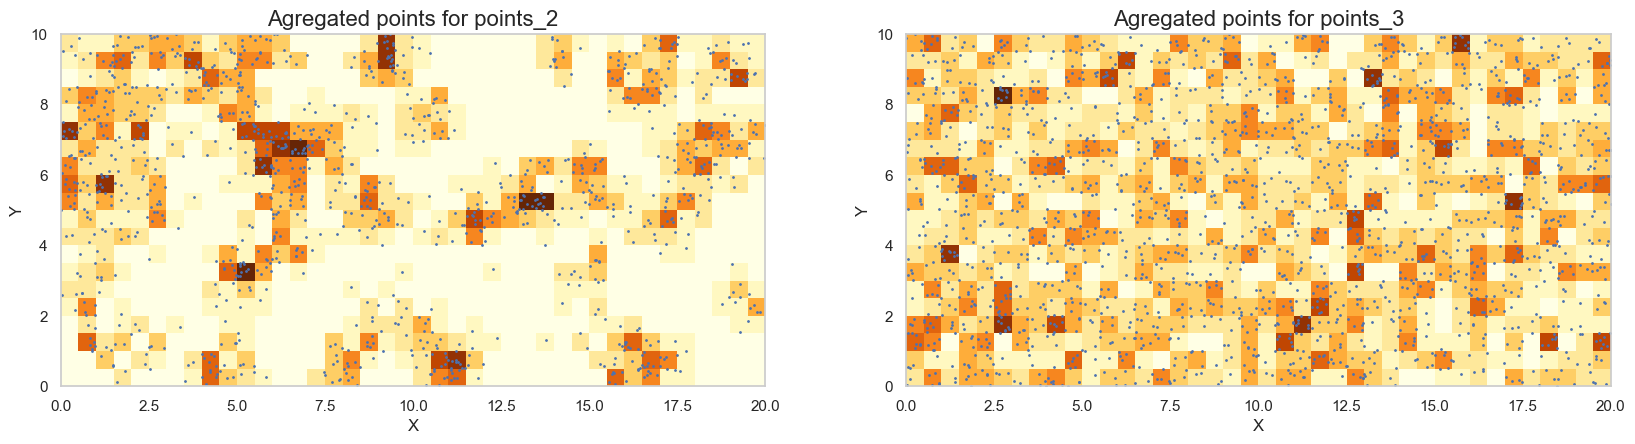

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (20,10))

axes[0].pcolormesh(binned_data2[0], binned_data2[1], binned_data2[2], cmap=cmap)
axes[0].set_title("Agregated points for points_2", fontsize = 16)
axes[0].set_xlabel("X")            
axes[0].set_ylabel("Y")   
axes[0].scatter(df2["X"], df2["Y"], s = 1)
axes[0].axis('square')
axes[0].set_ylim([0,10])
axes[0].set_xlim([0,20])

axes[1].pcolormesh(binned_data3[0], binned_data3[1], binned_data3[2], cmap=cmap)
axes[1].set_title("Agregated points for points_3", fontsize = 16)
axes[1].set_xlabel("X")            
axes[1].set_ylabel("Y")   
axes[1].scatter(df3["X"], df3["Y"], s = 1)
axes[1].axis('square')
axes[1].set_ylim([0,10])
axes[1].set_xlim([0,20]);

### Zadanie 3: Tablica sąsiedztwa (11 pkt)

Przygotuj funkcję `spatial_weights()`, która będzie przygotowywać tablicę sąsiedztwa podobszarów.

Schemat generowania tablicy sąsiedztwa:

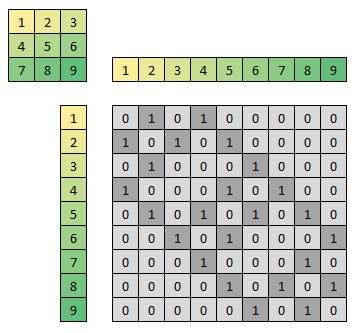

Następnie wykorzystaj przygotowaną funkcję do wykonania tablic sąsiedztwa zagregowanych danych z zadania 2.

Przedstaw wyniki analizy graficznie za pomocą wykresów heatmap. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [11]:
def spatial_weights(bin_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.

    Returns
    -------
    w: array
        Macierz 2D zawierająca wagi przestrzenne.
    """    
    points = [(i, j) for i in range(bin_counts.shape[0]) for j in range(bin_counts.shape[1])]
    distances = sp.spatial.distance.cdist(points, points)
    weights = (distances == 1) * 1
    return weights

#### b) Wygenerowanie danych

In [12]:
weights2 = spatial_weights(binned_data2[2])
weights3 = spatial_weights(binned_data2[2])

#### c) Wizualizacja

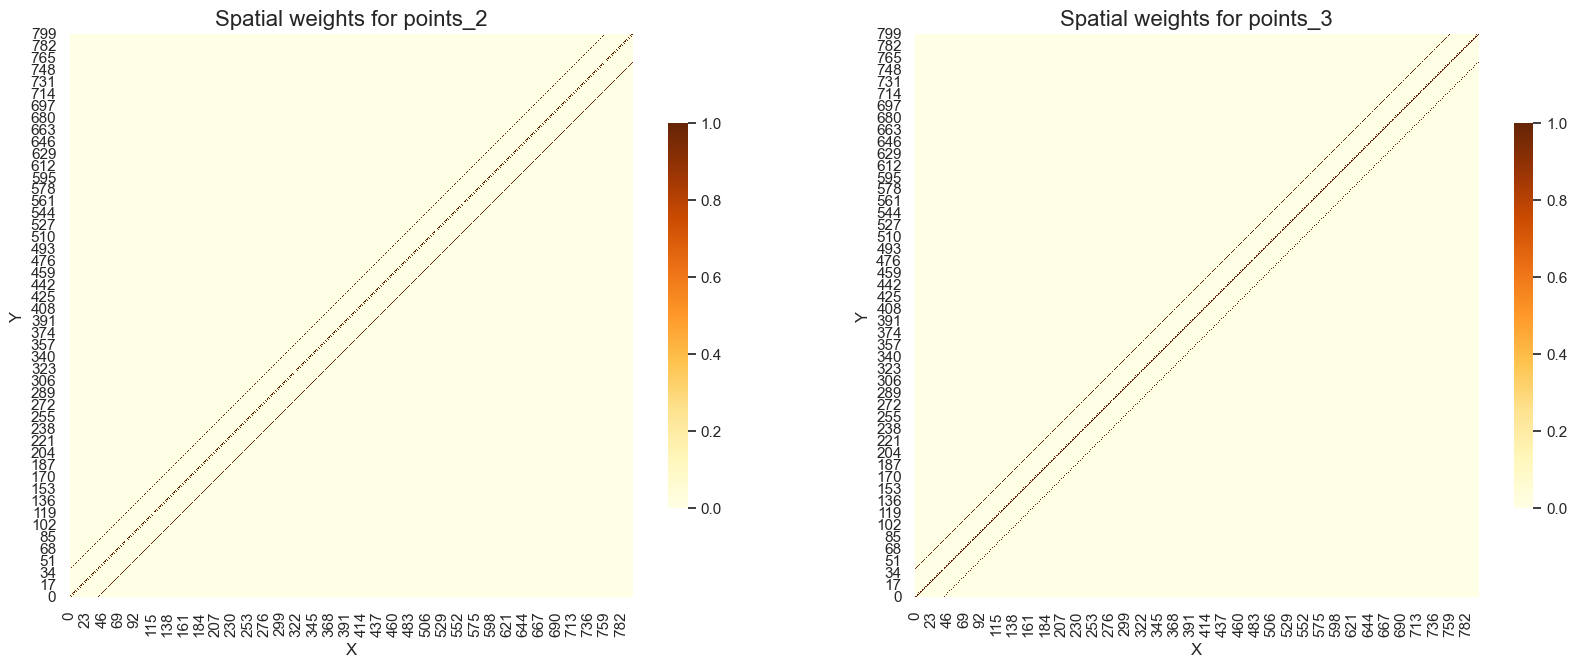

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (20,10))

sns.heatmap(weights2, ax = axes[0], cmap=cmap, cbar_kws={'shrink': 0.5})
axes[0].set_title("Spatial weights for points_2", fontsize = 16)
axes[0].set_xlabel("X")            
axes[0].set_ylabel("Y")
axes[0].axis('square')
axes[0].set_ylim([0,800])
axes[0].set_xlim([0,800])

sns.heatmap(weights3, ax = axes[1], cmap=cmap, cbar_kws={'shrink': 0.5})
axes[1].set_title("Spatial weights for points_3", fontsize = 16)
axes[1].set_xlabel("X")            
axes[1].set_ylabel("Y") 
axes[1].axis('square')
axes[1].set_ylim([0,800])
axes[1].set_xlim([0,800]);

### Zadanie 4: Opóźnienie przestrzenne (11 pkt)

Przygotuj funkcję `spatial_lag()`, która będzie przygotowywać tablicę wartości opóźnienia przestrzennego.

Następnie wykorzystaj przygotowaną funkcję do wyznaczania tablic opóźnienia przestrzennego zagregowanych danych z zadania 2.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych zestawionych z danymi zagregowanymi na podstawie których zostały one wykonane. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2). Umieść zagreowane dane w górnym wierszu, a opóźnienie przestrzenne w dolnym wierszu figury.

Algorytm postępowania:
1) Spłaszczamy macierz zliczeń w podobszarach.
2) Obliczamy poszczególne wartości tablicy opóźnienia przestrzennego zgodnie ze wzorem: <br/>
$ LC_{i} = \frac {\sum_j w_{ij} \cdot X_j} {\sum_j w_{ij}}$  <br/>
gdzie: $w$ - macierz sąsiedztwa, $X$ - spłaszczona macierz zliczeń w podobszarach. 
3) Konwertujemy tablicę opóźnienia przestrzennego do tych samych wymiarów jakie miała wejściowa macierz zliczeń w podobszarach.

#### a) Przygotowanie funkcji

In [14]:
def spatial_lag(binned_data):
    """
    Parameters
    -------
    binned_data: listb
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]

    Returns
    -------
    lagged_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wyliczonymi wartościami opóźnienia przestrzennego.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """    
    weights = spatial_weights(binned_data[2])
    binned_flat = binned_data[2].flatten()

    rows = weights.shape[0]    
    lagged_subs = [sum(weights[i,:]*binned_flat)/sum(weights[i,:]) for i in range(rows)]
        
    return [binned_data[0], binned_data[1], np.reshape(lagged_subs, binned_data[2].shape)]    

#### b) Wygenerowanie danych

In [15]:
lagged_data2 = spatial_lag(binned_data2)
lagged_data3 = spatial_lag(binned_data3)

#### c) Wizualizacja

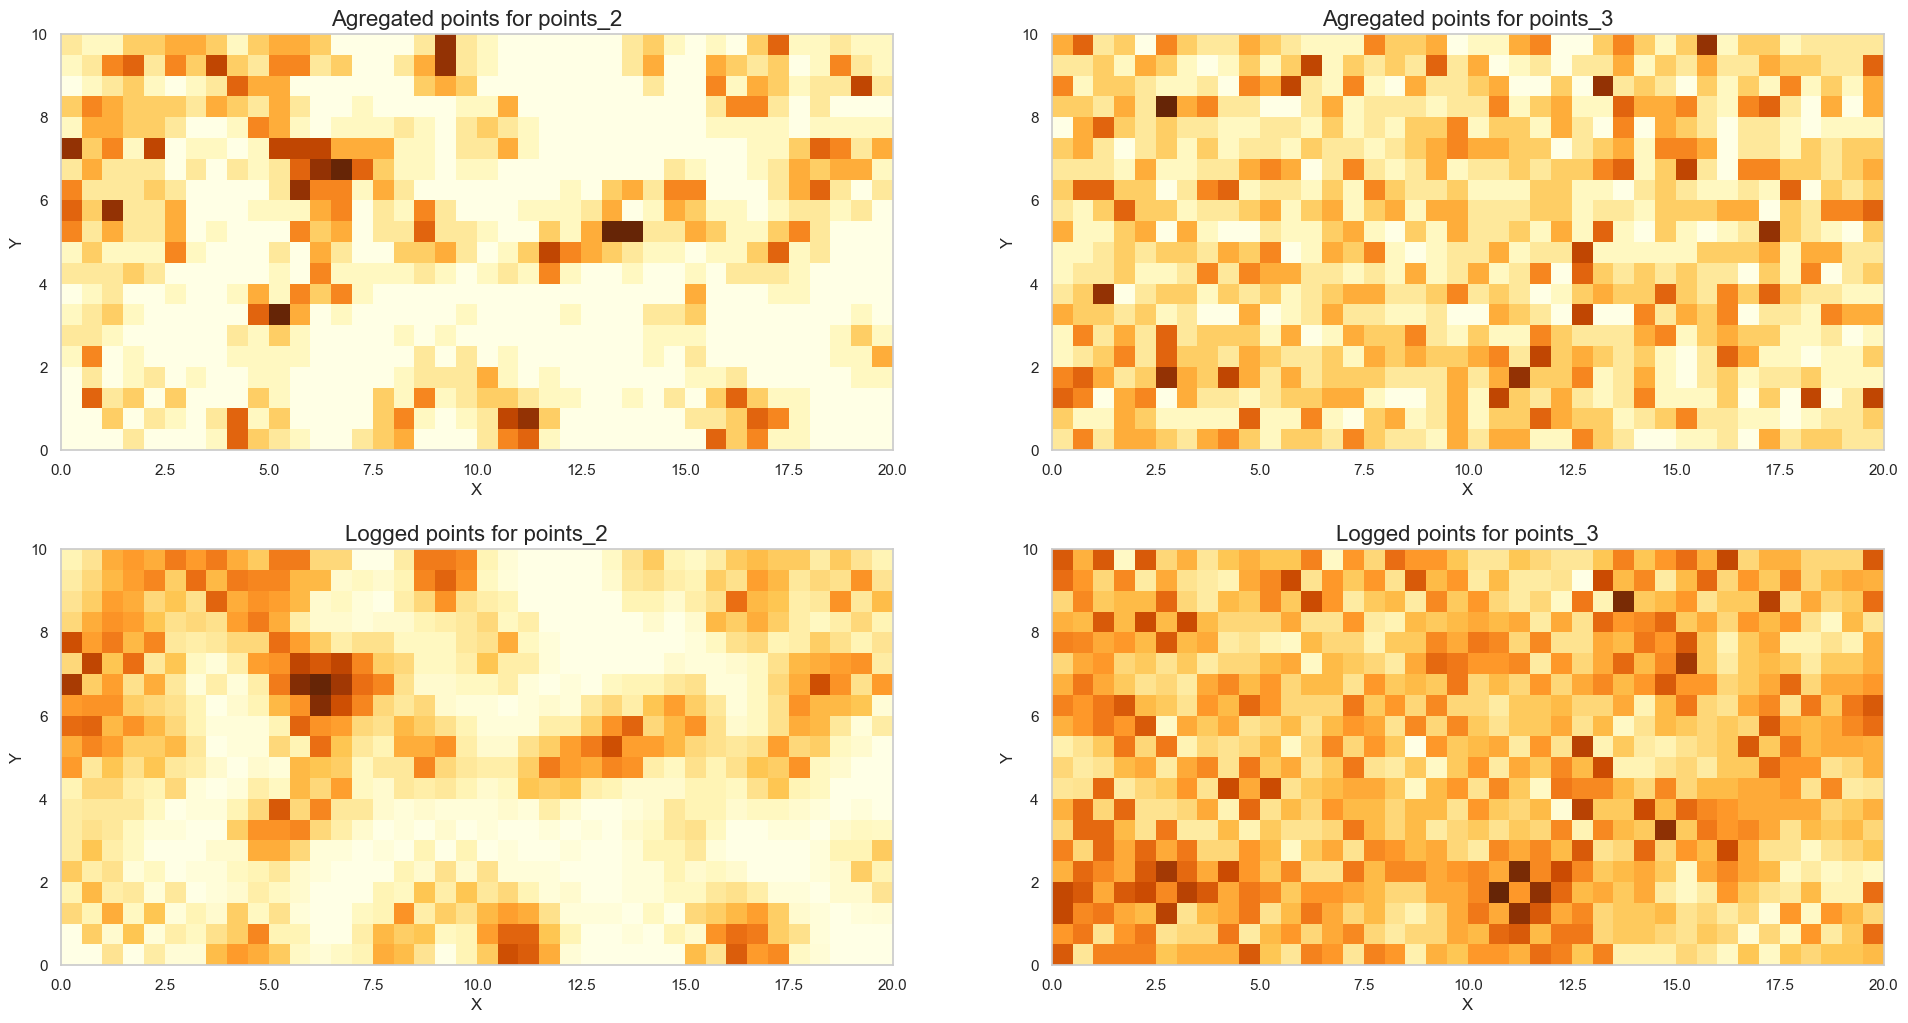

In [16]:
fig, axes = plt.subplots(2, 2, figsize = (20,10))
fig.tight_layout(h_pad=4.0)

axes[0][0].pcolormesh(binned_data2[0], binned_data2[1], binned_data2[2], cmap=cmap)
axes[0][0].set_title("Agregated points for points_2", fontsize = 16)
axes[0][0].set_xlabel("X")            
axes[0][0].set_ylabel("Y")   
axes[0][0].axis('square')
axes[0][0].set_ylim([0,10])
axes[0][0].set_xlim([0,20])

axes[0][1].pcolormesh(binned_data3[0], binned_data3[1], binned_data3[2], cmap=cmap)
axes[0][1].set_title("Agregated points for points_3", fontsize = 16)
axes[0][1].set_xlabel("X")            
axes[0][1].set_ylabel("Y")   
axes[0][1].axis('square')
axes[0][1].set_ylim([0,10])
axes[0][1].set_xlim([0,20]);

axes[1][0].pcolormesh(lagged_data2[0], lagged_data2[1], lagged_data2[2], cmap=cmap)
axes[1][0].set_title("Logged points for points_2", fontsize = 16)
axes[1][0].set_xlabel("X")            
axes[1][0].set_ylabel("Y")   
axes[1][0].axis('square')
axes[1][0].set_ylim([0,10])
axes[1][0].set_xlim([0,20])

axes[1][1].pcolormesh(lagged_data3[0], lagged_data3[1], lagged_data3[2], cmap=cmap)
axes[1][1].set_title("Logged points for points_3", fontsize = 16)
axes[1][1].set_xlabel("X")            
axes[1][1].set_ylabel("Y")   
axes[1][1].axis('square')
axes[1][1].set_ylim([0,10])
axes[1][1].set_xlim([0,20]);

### Zadanie 5: Wykres Morana (11 pkt)

Przygotuj funckję `moran_plot_data()`, która będzie przygotowywać dane niezbędne do wykonania wykresu Morana. Wykres Morana to zestawienie wartości z macierzy zliczeń ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś x) z wartościami z macierzy opóźnienia przestrzennego ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś y) z nałożoną na nie prostą regresji.

Następnie wykorzystaj przygotowaną funkcję do przygotowanie danych do wykonania wykresu Morana zagregowanych danych z zadania 2. 

Przedstaw wyniki analizy graficznie w postaci wykresów Morana zestawionych z danymi zagregowanymi na podstawie których zostały wykonane przedstawionymi w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2). Umieść zagreowane dane w górnym wierszu, a wykresy Morana w dolnym wierszu figury.

#### a) Przygotowanie funkcji

In [17]:
def moran_plot_data(bin_counts, lagged_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.
    lagged_counts: array
        Macierz 2D z wartościami opóźnienia przestrzennego przypisanego do każdego z podobszarów.

    Returns
    -------
    moran_plot_data: DataFrame
        Tablica zawierająca dwie kolumny danych niebędnych do wykonania wykresu Morana:
        - "AG_STD" - ustandarywowane dane zagregowane,
        - "SL_STD" - ustandarywzowane wartości opóźnienia przestrzennego.
    """ 
    AG_STD = bin_counts.flatten() - bin_counts.mean()
    SL_STD = lagged_counts.flatten() - lagged_counts.mean()
    return pd.DataFrame({"AG_STD" : AG_STD, "SL_STD" : SL_STD})

#### b) Wygenerowanie danych

In [18]:
moran2 = moran_plot_data(binned_data2[2], lagged_data2[2])
moran3 = moran_plot_data(binned_data3[2], lagged_data3[2])

#### c) Wizualizacja

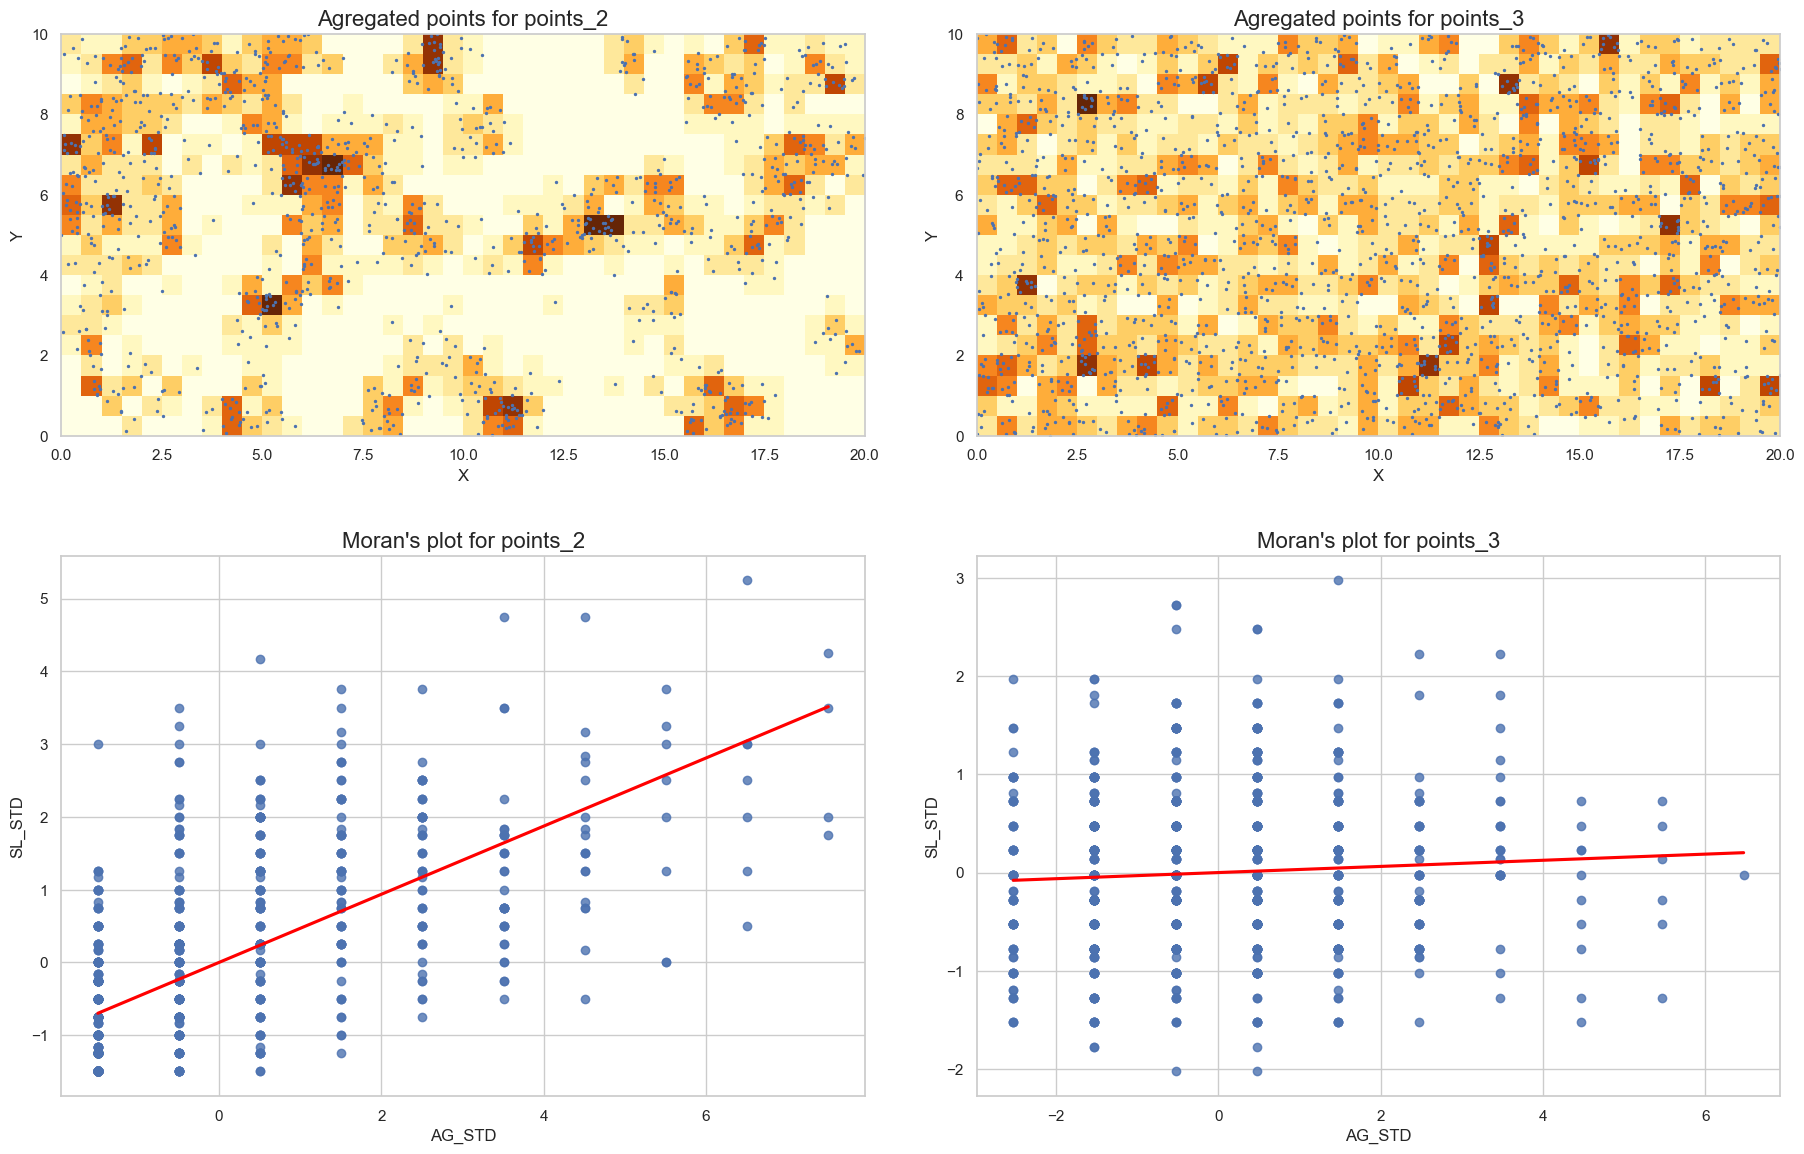

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.tight_layout(w_pad=4)

axes[0][0].pcolormesh(binned_data2[0], binned_data2[1], binned_data2[2], cmap=cmap)
axes[0][0].scatter(df2["X"], df2["Y"], s = 2)
axes[0][0].set_title("Agregated points for points_2", fontsize = 16)
axes[0][0].set_xlabel("X")            
axes[0][0].set_ylabel("Y")   
axes[0][0].axis('square')
axes[0][0].set_ylim([0,10])
axes[0][0].set_xlim([0,20])

axes[0][1].pcolormesh(binned_data3[0], binned_data3[1], binned_data3[2], cmap=cmap)
axes[0][1].scatter(df3["X"], df3["Y"], s = 2)
axes[0][1].set_title("Agregated points for points_3", fontsize = 16)
axes[0][1].set_xlabel("X")            
axes[0][1].set_ylabel("Y")   
axes[0][1].axis('square')
axes[0][1].set_ylim([0,10])
axes[0][1].set_xlim([0,20]);

sns.regplot(data = moran2, x = "AG_STD", y = "SL_STD", ax = axes[1][0], ci = None, line_kws = {"color" : "red"})
axes[1][0].set_title("Moran's plot for points_2", fontsize = 16)

sns.regplot(data = moran3, x = "AG_STD", y = "SL_STD", ax = axes[1][1], ci = None, line_kws = {"color" : "red"})  
axes[1][1].set_title("Moran's plot for points_3", fontsize = 16);